train loss: 1.18e-01 | test loss: 1.13e-01 | reg: 1.65e+01 : 100%|██| 20/20 [00:04<00:00,  4.24it/s]
train loss: 6.76e-04 | test loss: 6.78e-04 | reg: 7.14e-01 : 100%|██| 50/50 [00:05<00:00,  9.52it/s]


fixing (0,0,0) with x^2, r2=0.9997024536132812
fixing (0,1,0) with exp, r2=0.6842756867408752
fixing (1,0,0) with sin, r2=0.9994066953659058


train loss: 1.40e-02 | test loss: 1.42e-02 | reg: 7.32e-01 : 100%|██| 50/50 [00:00<00:00, 67.98it/s]


-1.02*sin(121.98*(0.01*x_1 + 1)**2 - 125.13)

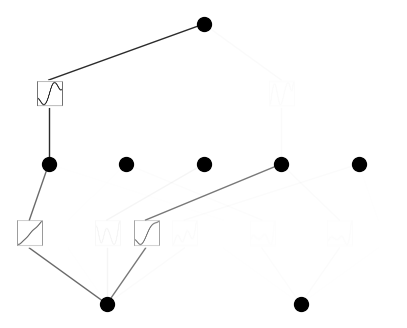

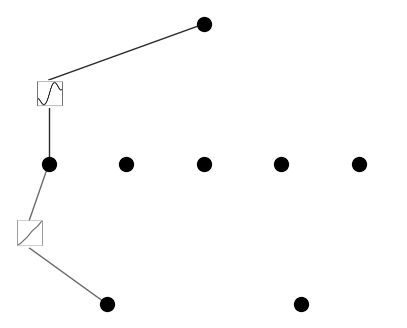

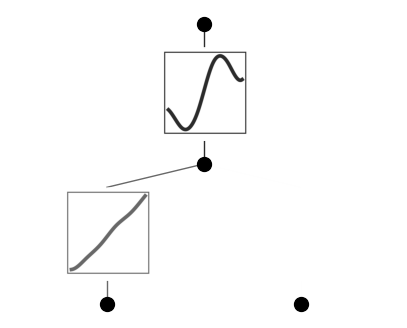

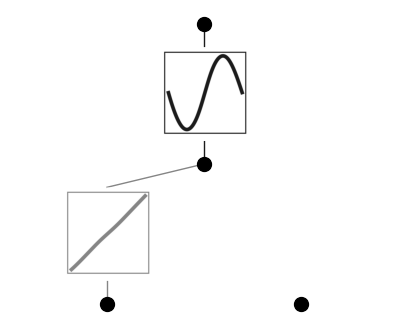

In [4]:
from kan import *


model = KAN(width=[2,5,1], grid=5, k=3, seed=0 )

# f is target function
f = lambda x: torch.sin(torch.pi*x[:,[0]]) #+ torch.cos(torch.pi*x[:,[1]]) # + torch.log(1 + x[:,[0]]**2 + x[:,[1]]**2)
#f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)


# create dataset derived from target function
dataset = create_dataset(f, n_var=2)

#lamb,lamb+entropy parameter is needed when restoring original function 
model.train(dataset, opt="LBFGS", steps=20,lamb=0.01, lamb_entropy=10.);


# iteratively fining spline function for better fitting don't need this block to restore function

"""
grids = np.array([5,10,15,20,25])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,10,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,10,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
  
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')
"""

# to restore original function and distinguish random-generating situation, we use explainability of KAN under this line

# original trained model
model.plot()

# prune model
model.prune() 
model.plot(mask=True)

# give smaller shape
model = model.prune() 
model(dataset['train_input'])
model.plot() 

# Continue training and replot
model.train(dataset, opt="LBFGS", steps=50);
model.plot()

#automatically find target fucntion  
mode = "auto" 

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

model.train(dataset, opt="LBFGS", steps=50);
model.symbolic_formula()[0][0]






In [3]:

# to find out better hyperparameter, we will use auto ml under this line
import numpy as np
import torch
import optuna
from sklearn.model_selection import train_test_split
from kan import KAN, create_dataset

# Define the target function
f = lambda x: torch.sin(3 * torch.pi * x[:, [0]])

# Create dataset derived from target function
def create_dataset(f, n_var=2, n_samples=1000):
    X = np.random.rand(n_samples, n_var)
    y = f(torch.tensor(X, dtype=torch.float32)).numpy().flatten()
    return X, y

# Generate the dataset
X, y = create_dataset(f, n_var=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.float32)


# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    width = trial.suggest_categorical('width', [(2, 5, 1), (2,7,1)])
    grid = trial.suggest_int('grid', 5, 7, step=1)
    
    # Initialize and train the KAN model
    model = KAN(width=width, grid=grid, k=3, seed=0)
    dataset = {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }
    model.train(dataset, opt="LBFGS", steps=20,lamb=0.01, lamb_entropy=10.)
    
    # Evaluate the model on the test set
    y_pred = model(test_input).detach().numpy()
    test_loss = np.mean((y_pred - y_test) ** 2)
    
    return test_loss

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)


# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
model = KAN(width=best_params['width'], grid=best_params['grid'], k=3, seed=0)
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}
model.train(dataset, opt="LBFGS", steps=20,lamb=0.01, lamb_entropy=10.)

# Evaluate the final model
y_pred = model(test_input).detach().numpy()
test_loss = np.mean((y_pred - y_test) ** 2)
print(f"Final Test Loss: {test_loss}")




[I 2024-06-21 08:14:42,386] A new study created in memory with name: no-name-41e14a59-b449-4871-85d0-0478608eba10
train loss: 6.84e-01 | test loss: 6.89e-01 | reg: 3.12e+01 : 100%|██| 20/20 [00:06<00:00,  2.94it/s]
[I 2024-06-21 08:14:49,197] Trial 0 finished with value: 0.47471386194229126 and parameters: {'width': (2, 7, 1), 'grid': 5}. Best is trial 0 with value: 0.47471386194229126.
train loss: 6.83e-01 | test loss: 6.89e-01 | reg: 3.10e+01 : 100%|██| 20/20 [00:05<00:00,  3.45it/s]
[I 2024-06-21 08:14:55,005] Trial 1 finished with value: 0.4748629331588745 and parameters: {'width': (2, 5, 1), 'grid': 6}. Best is trial 0 with value: 0.47471386194229126.
train loss: 6.83e-01 | test loss: 6.89e-01 | reg: 3.05e+01 : 100%|██| 20/20 [00:06<00:00,  2.91it/s]
[I 2024-06-21 08:15:01,891] Trial 2 finished with value: 0.4744471609592438 and parameters: {'width': (2, 7, 1), 'grid': 5}. Best is trial 2 with value: 0.4744471609592438.
train loss: 6.83e-01 | test loss: 6.90e-01 | reg: 3.53e+01 : 

Best hyperparameters:  {'width': (2, 7, 1), 'grid': 5}


train loss: 6.83e-01 | test loss: 6.89e-01 | reg: 3.01e+01 : 100%|██| 20/20 [00:07<00:00,  2.79it/s]

Final Test Loss: 0.47423115372657776
